In [1]:
# replace draw with rank of draw for better alignment

In [3]:
import pandas as pd

In [5]:
import seaborn as sns

In [6]:
import numpy as np

In [7]:
from matplotlib import pyplot as plt

In [8]:
fpath = 'data/prep/'
dfile = 'form_data_v2.0.csv'

In [19]:
df = pd.read_csv( fpath + dfile, header=0, parse_dates=True )

In [20]:
# flat races
df = df[df.Type.isna()]

In [21]:
# remove entries with missing Draw - some of these could be imputed or manually entered
# print(df.RaceId[df.Draw.isna()].unique())
df = df[~df.Draw.isna()]

In [22]:
# no. declared from max draw by race, ie FieldSize + RR + withdrawn
DeclFieldSize = df[['RaceId', 'Draw']].groupby('RaceId').max().squeeze().rename('DeclFieldSize').astype(int)

In [23]:
df = df.join(DeclFieldSize, on='RaceId')

In [35]:
# rank of draw by race
df['DrawRank'] = df[['RaceId', 'Draw']].groupby('RaceId').rank('first').astype(int)

In [39]:
# no. stalls from max draw rank by race ( ==FieldSize ?? == grouby count ?? )
N_Stalls = df[['RaceId', 'DrawRank']].groupby('RaceId').max().squeeze().rename('N_Stalls').astype(int)

In [41]:
df = df.join(N_Stalls, on='RaceId')

In [49]:
# df[df.FieldSize != df.N_Stalls][['RaceId','FieldSize','DeclFieldSize','N_Stalls']]

In [51]:
# replace non-numeric Posn with last place and cast to int TODO
# df[~df.Posn.str.isnumeric(), 'Posn'] = df[~df.Posn.str.isnumeric(), 'DeclFieldSize']
df['Posn'] = df.apply(lambda r: int(r.Posn) if r.Posn.isnumeric() else r.DeclFieldSize, axis=1)

In [111]:
def xmast(data, course_name, dist=None, going=None, min_ave_supp=3):
    if dist:
        dist_mask = data.Distance.apply(lambda x: x in dist)
    else:
        dist_mask = True
    if going:
        going_mask = data.Going1.apply(lambda x: x in going)
    else:
        going_mask = True
    dat = data[(data.CourseName==course_name) & dist_mask & going_mask]
    dat = pd.DataFrame({'N_Stalls': dat.N_Stalls, 
                        'DrawRank': dat.DrawRank.apply(int),
                        # TODO index options as argument
                        'Index': dat.apply(lambda r: r.ReturnWin * 2 if r.Sp < 7.5 else r.ReturnWin+r.ReturnPlace, axis=1)
                       })
    # TODO add other indexes as (string) options
    # create tables
    g = dat[['N_Stalls','DrawRank','Index']].groupby(['N_Stalls','DrawRank'])
    dat_sum = g.sum()
    dat_n = g.count()
    dat_sum = dat_sum.reset_index().pivot_table(index='N_Stalls',columns='DrawRank').fillna(0)
    dat_n = dat_n.reset_index().pivot_table(index='N_Stalls',columns='DrawRank').fillna(0)
    dat_sum.columns = dat_sum.columns.droplevel(0)
    dat_n.columns = dat_n.columns.droplevel(0)
    # aggregate to min_ave_supp
    min_fieldsize = dat_n.index.values.min()
    max_draw = dat_n.columns.values.max()
    dat_0 = pd.DataFrame(np.zeros([max_draw, max_draw]), index=np.arange(1,max_draw+1), columns=np.arange(1,max_draw+1))    
    dat_sum = (dat_sum + dat_0).fillna(0)
    dat_n = (dat_n  + dat_0).fillna(0) # NB. loses index name 'N_Stalls'    
    # # debugging
    dat_n_0 = dat_n.copy()
    dat_sum_0 = dat_sum.copy()
    dat_n = dat_n_0.copy()
    dat_sum = dat_sum_0.copy()
    row_idx = 0
    
    while ~np.all(dat_n.sum(axis=1) / dat_n.index.values >= min_ave_supp):
        # aggregate from top or bottom ?
        a = dat_n.index[dat_n.sum(axis=1) / dat_n.index.values < min_ave_supp].values
        row_idx = int(sum(a < len(dat_n)/2) > len(a)/2) - 1
        # # debugging
        # print(dat_n.sum(axis=1) / dat_n.index.values >= min_ave_supp)
        # print(row_idx)
        # print()
        vec1_n = dat_n.iloc[row_idx,:dat_n.index[row_idx]].values
        vec1_sum = dat_sum.iloc[row_idx,:dat_sum.index[row_idx]].values
        if row_idx == -1:
            # downsample last
            sample_mat = 1 / (len(vec1_n)-1) * \
                            (np.concatenate( [np.diag(np.arange(len(vec1_n)-1,0,-1)), np.zeros([len(vec1_n)-1,1]) ], axis=1) + \
                            np.concatenate( [np.zeros([len(vec1_n)-1,1]), np.diag(np.arange(1,len(vec1_n),1)) ], axis=1))
            vec2_n = np.matmul(sample_mat, vec1_n)
            vec2_sum = np.matmul(sample_mat, vec1_sum)
            # add to previous
            dat_n.iloc[row_idx-1,:len(vec2_n)] = dat_n.iloc[row_idx-1,:len(vec2_n)] + vec2_n
            dat_sum.iloc[row_idx-1,:len(vec2_sum)] = dat_sum.iloc[row_idx-1,:len(vec2_sum)] + vec2_sum
            # drop last row and column
            dat_n = dat_n.drop(index=dat_n.index[row_idx]).drop(columns=dat_n.columns[row_idx])
            dat_sum = dat_sum.drop(index=dat_sum.index[row_idx]).drop(columns=dat_sum.columns[row_idx])
        else:
            # upsample first
            sample_mat = 1 / (len(vec1_n)+1) * \
                            (np.concatenate( [np.diag(np.arange(len(vec1_n),0,-1)), np.zeros([1,len(vec1_n)]) ], axis=0) + \
                            np.concatenate( [np.zeros([1,len(vec1_n)]), np.diag(np.arange(1,len(vec1_n)+1,1)) ], axis=0))
            vec2_n = np.matmul(sample_mat, vec1_n)
            vec2_sum = np.matmul(sample_mat, vec1_sum)
            # add to next
            dat_n.iloc[row_idx+1,:len(vec2_n)] = dat_n.iloc[row_idx+1,:len(vec2_n)] + vec2_n
            dat_sum.iloc[row_idx+1,:len(vec2_sum)] = dat_sum.iloc[row_idx+1,:len(vec2_sum)] + vec2_sum
            # drop first row
            dat_n = dat_n.drop(index=dat_n.index[row_idx])
            dat_sum = dat_sum.drop(index=dat_sum.index[row_idx])
    # center non-zero values for heatmap
    # TODO option for 'inside' , 'centre', 'outside' stalls position
    # TODO ordering of draw in stalls : low-to-high , high-to-low ?? ( & historical changes thereto )
    i2 = dat_sum.index.values
    n_draw = dat_sum.shape[1]
    i1 = (n_draw - i2)//2

    dat_sum_np = dat_sum.to_numpy()
    dat_n_np = dat_n.to_numpy()
    hm_dat_sum_np = np.zeros(dat_sum_np.shape)
    hm_dat_n_np = np.zeros(dat_n_np.shape)

    for i in range(hm_dat_sum_np.shape[0]):
        hm_dat_sum_np[ i, i1[i]:(i1[i]+i2[i]) ] = dat_sum_np[ i, :i2[i]] 
        hm_dat_n_np[ i, i1[i]:(i1[i]+i2[i]) ] = dat_n_np[ i, :i2[i]]
            
    # hm_data = pd.DataFrame(hm_dat_sum_np / hm_dat_n_np, # div by zero
    hm_data = pd.DataFrame(np.divide(hm_dat_sum_np, hm_dat_n_np, where=hm_dat_n_np>0, out=np.zeros(hm_dat_sum_np.shape)),
                            index=dat_sum.index.rename('N_Stalls'),
                            columns=dat_sum.columns.rename('Draw Rank (low to high, centered)'))
    # normalize the rows
    # TODO this is messy and loses the index and label
    hm_data = hm_data.reset_index().apply(lambda r: r[1:]/sum(r[1:])*r.N_Stalls, axis=1)
    hm_annot = pd.DataFrame(np.round(np.log(hm_dat_n_np+1)).astype(int).astype(str),
                            index=dat_sum.index.rename('N_Stalls'),
                            columns=dat_sum.columns.rename('Draw Rank (low to high, centered)')).replace('0','')
    # return (hm_data, hm_annot)
    return (hm_data, hm_annot)


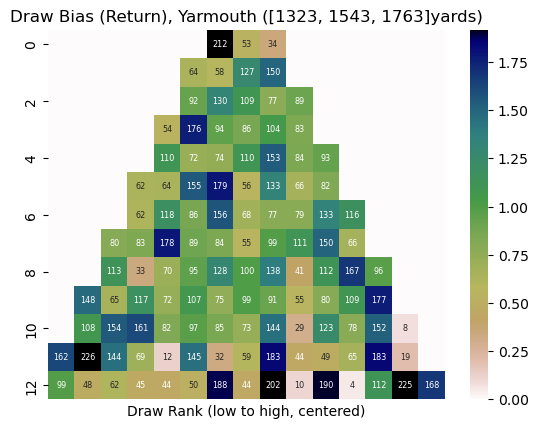

In [129]:
%matplotlib inline
# course_name = 'Nottingham'
# dist = 8*220 + 75

# min_ave_supp = 3
# course_name = 'Newbury'
# dist = [ x * 220 for x in [ 6, 6.5, 7 ] ]
# going = [ 'goodtofirm', 'good', 'goodtosoft' ]
course_name = 'Yarmouth'
dist = [ x * 220 + 3 for x in [6,7,8] ]
going = [ 'goodtofirm', 'good', 'goodtosoft' ]
min_ave_supp = 10

plt.figure()
plt.title('Draw Bias (Return), ' + course_name + ' (' + str(dist) + 'yards)')
hm_data, hm_annot = xmast(df, course_name, dist=dist, going=going, min_ave_supp=min_ave_supp)

# TODO fix hm_data.index for correct y-axis (FieldSize) label and ticklabels
sns.heatmap(hm_data,
    cmap='gist_earth_r', robust=True,
    # annot=hm_annot, fmt='', annot_kws={'fontsize': 'xx-small'},
    annot=(hm_data*100).astype(int).astype(str).replace('0',''), fmt='', annot_kws={'fontsize': 'xx-small'},
    xticklabels=False, yticklabels=2
    )
plt.show()
# plt.savefig('xmast_' + course_name + '.png')
plt.close()

In [125]:
hm_data

"Draw Rank (low to high, centered)",1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.121670,0.531668,0.346663,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.643484,0.584138,1.272369,1.500009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.921370,1.308344,1.099072,0.772870,0.898345,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.545852,1.761976,0.944690,0.867938,1.042673,0.836871,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.105246,0.725924,0.747603,1.102621,1.534738,0.848682,0.935187,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.629780,0.649290,1.550102,1.793868,0.561412,1.330805,0.660427,0.824315,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.623718,1.181389,0.866982,1.568336,0.686570,0.779282,0.791811,1.337917,1.163995,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.806338,0.835254,1.785098,0.896998,0.840750,0.558695,0.991764,1.111859,1.508972,0.664273,0.000000,0.000000,0.000000
8,0.000000,0.000000,1.134526,0.339604,0.707351,0.956432,1.284351,1.000720,1.384549,0.416495,1.128307,1.678231,0.969435,0.000000,0.000000
9,0.000000,1.480004,0.656101,1.174606,0.726242,1.071576,0.751010,0.996155,0.912837,0.556965,0.808129,1.093055,1.773320,0.000000,0.000000
